In [6]:
# Precipitation - inches (accumulation)  
# Temperature - Fahrenheit  
# Streamflow - ft³/s

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [8]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="When grouping with a length-1 list-like, you will need to pass a length-1 tuple"
)

# Data Prep for Visualization

In [9]:
import pandas as pd

df_x = pd.read_csv('data/streamflow_prediction_dataset.csv').iloc[:, [0,7,8,9,10]]
df_x['date'] = pd.to_datetime(df_x['date'])
df_x['PRCP'] = df_x['PRCP_BisonLake'] + df_x['PRCP_McClurePass']
df_x['TAVG'] = (df_x['TAVG_BisonLake'] + df_x['TAVG_McClurePass']) / 2
df_x['PREC_year'] = df_x.groupby(df_x['date'].dt.year)['PRCP'].cumsum()
df_x = df_x[['date', 'TAVG', 'PREC_year']]

df_y = pd.read_csv('data/streamflow_prediction_dataset.csv')[['date', 'streamflow']]
df_y['date'] = pd.to_datetime(df_y['date'])

# merge feature and target data
df = pd.merge(df_x, df_y, on='date')

# set the date as index, handle missing values
df = df.set_index('date')

# recalculate day of year (DOY) and year
df['DOY'] = df.index.to_series().dt.dayofyear
df['year'] = df.index.year

# reorder columns
df = df[['year', 'DOY', 'TAVG', 'PREC_year', 'streamflow']]

# display
display(df)

,year,DOY,TAVG,PREC_year,streamflow
date,,,,,
2008-03-12,2008,72,24.80,0.1,2360.0
2008-03-15,2008,75,17.55,0.4,2260.0
2008-03-17,2008,77,19.35,0.6,2260.0
2008-03-18,2008,78,17.85,0.6,2260.0
2008-03-19,2008,79,25.50,0.6,2200.0
...,...,...,...,...,...
2021-07-23,2021,204,57.50,33.2,1170.0
2021-07-24,2021,205,55.85,33.6,1240.0
2021-07-25,2021,206,55.15,34.1,1190.0


In [10]:
print(df.isnull().sum() / len(df))
df = df.dropna()
print(df.isnull().sum() / len(df))
display(df)

year          0.0
DOY           0.0
TAVG          0.0
PREC_year     0.0
streamflow    0.0
dtype: float64
year          0.0
DOY           0.0
TAVG          0.0
PREC_year     0.0
streamflow    0.0
dtype: float64


,year,DOY,TAVG,PREC_year,streamflow
date,,,,,
2008-03-12,2008,72,24.80,0.1,2360.0
2008-03-15,2008,75,17.55,0.4,2260.0
2008-03-17,2008,77,19.35,0.6,2260.0
2008-03-18,2008,78,17.85,0.6,2260.0
2008-03-19,2008,79,25.50,0.6,2200.0
...,...,...,...,...,...
2021-07-23,2021,204,57.50,33.2,1170.0
2021-07-24,2021,205,55.85,33.6,1240.0
2021-07-25,2021,206,55.15,34.1,1190.0


In [11]:
# experimental features
df_exp = pd.read_csv('data/streamflow_prediction_dataset.csv')
df_exp

,date,SNWD_BisonLake,SNWD_McClurePass,WTEQ_BisonLake,WTEQ_McClurePass,PREC_BisonLake,PREC_McClurePass,PRCP_BisonLake,PRCP_McClurePass,TAVG_BisonLake,...,soilmoisture_station607_4ft,soilmoisture_station607_8ft,soilmoisture_station607_20ft,soilmoisture_station680_2ft,soilmoisture_station680_8ft,soilmoisture_station680_20ft,soilmoisture_station802_2ft,soilmoisture_station802_8ft,soilmoisture_station802_20ft,streamflow
0,2008-03-12,82.0,60.0,28.6,23.9,29.1,22.9,0.1,0.0,19.4,...,10.2,24.2,25.8,14.6,11.7,26.0,4.0,1.3,6.5,2360.0
1,2008-03-15,86.0,63.0,29.2,24.5,29.7,23.4,0.1,0.2,11.7,...,10.3,24.4,25.4,14.7,11.7,26.2,4.0,1.4,6.9,2260.0
2,2008-03-17,84.0,63.0,29.3,24.8,29.8,23.6,0.0,0.2,14.4,...,10.3,24.7,25.2,14.4,12.1,26.1,4.1,1.4,6.7,2260.0
3,2008-03-18,83.0,62.0,29.3,24.8,29.8,23.6,0.0,0.0,11.8,...,10.6,24.9,25.3,14.7,12.1,26.0,4.0,1.4,6.6,2260.0
4,2008-03-19,82.0,61.0,29.4,24.9,29.8,23.6,0.0,0.0,20.8,...,10.6,25.0,25.1,14.6,11.7,25.9,4.0,1.6,6.9,2200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,2021-07-23,0.0,0.0,0.0,0.0,27.7,20.7,0.2,0.2,52.9,...,13.8,14.5,11.5,35.5,14.2,30.2,24.1,5.5,9.2,1170.0
2992,2021-07-24,0.0,0.0,0.0,0.0,27.7,21.1,0.0,0.4,54.7,...,13.4,14.1,11.3,33.7,13.9,30.2,24.0,5.3,8.7,1240.0
2993,2021-07-25,0.0,0.0,0.0,0.0,27.8,21.5,0.1,0.4,52.7,...,13.1,13.9,10.8,39.8,13.8,30.2,23.8,5.0,8.1,1190.0
2994,2021-07-26,0.0,0.0,0.0,0.0,27.8,21.5,0.0,0.0,57.0,...,12.9,13.9,10.4,37.7,14.1,30.2,23.7,4.8,7.0,1170.0


# Visualize

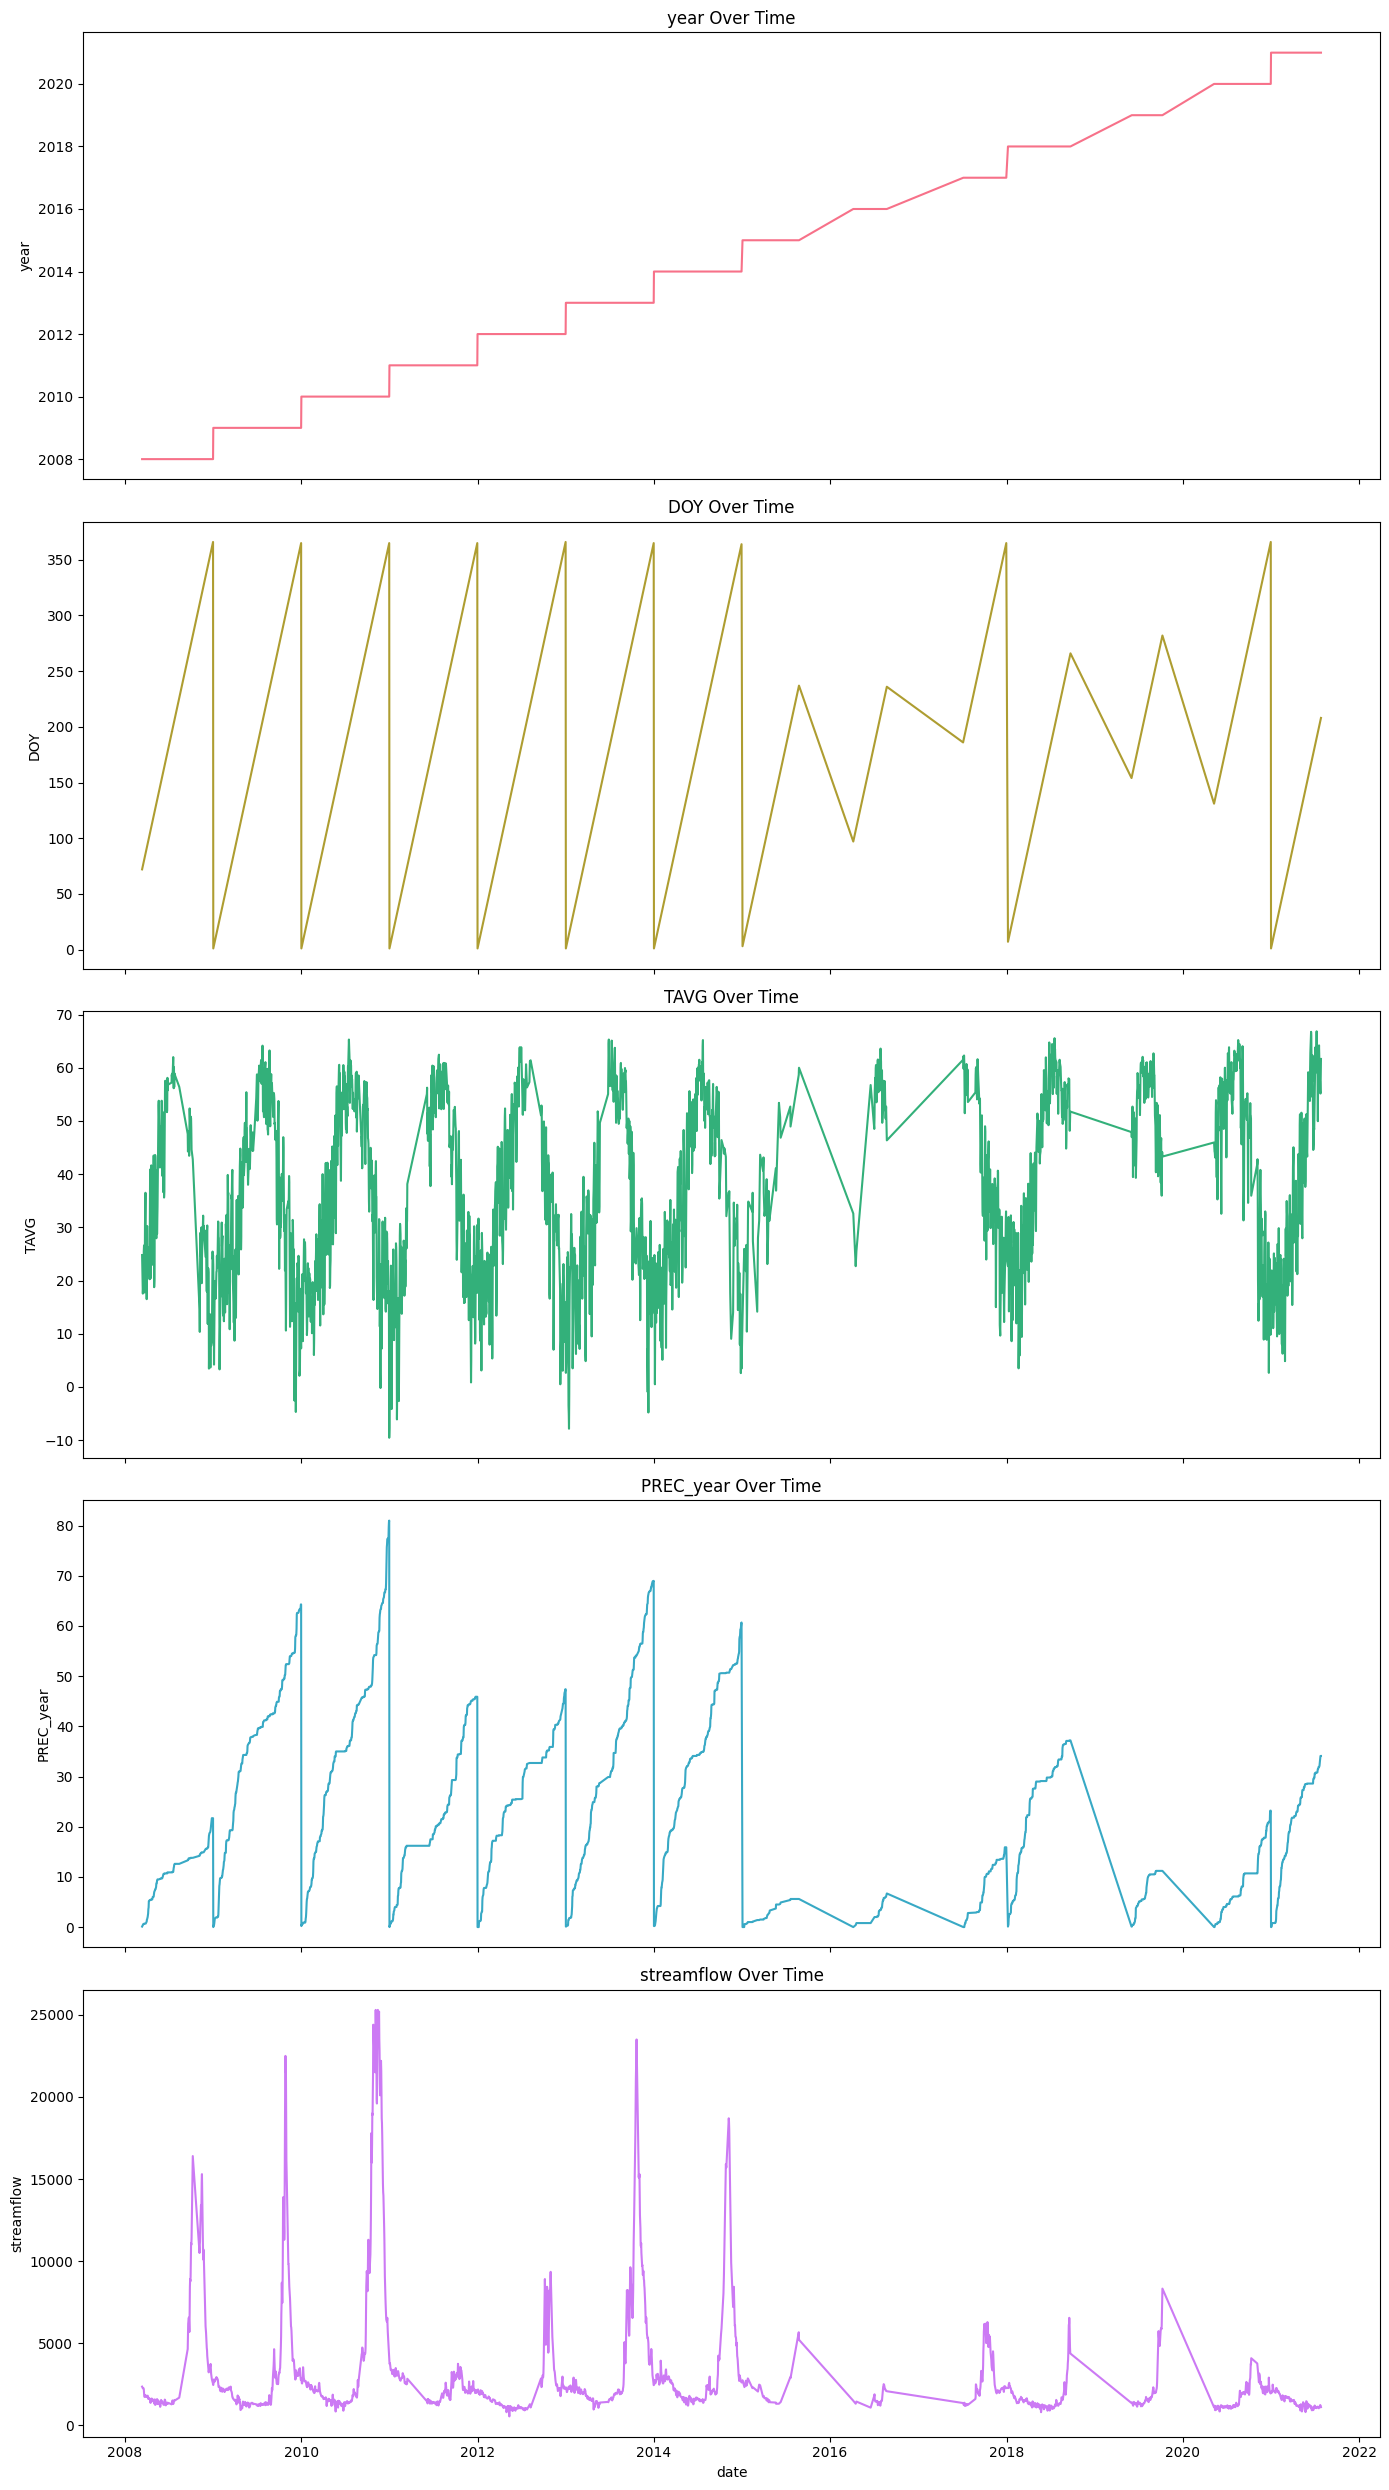

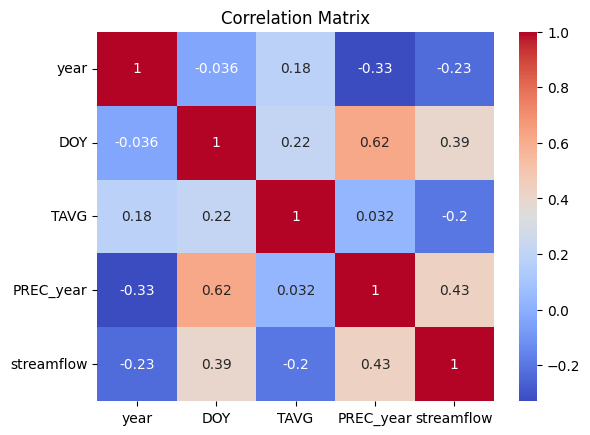

In [12]:
def plot_data(df):
    # Drop rows with NaN values for cleaner plotting
    df_cleaned = df.dropna()
    
    # Number of subplots needed
    num_columns = len(df_cleaned.columns)
    
    # Create subplots
    fig, axs = plt.subplots(num_columns, 1, figsize=(14, 5 * num_columns), sharex=True)
    
    # Ensure axs is iterable (even if there's only one subplot)
    if num_columns == 1:
        axs = [axs]
    
    # Generate colors for the plots
    colors = sns.color_palette("husl", num_columns)
    
    # Plot each column
    for i, column in enumerate(df_cleaned.columns):
        sns.lineplot(data=df_cleaned, x=df_cleaned.index, y=column, ax=axs[i], color=colors[i])
        axs[i].set_ylabel(column)
        axs[i].set_title(f'{column} Over Time')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Plot the correlation matrix
    corr = df_cleaned.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
    
plot_data(df)

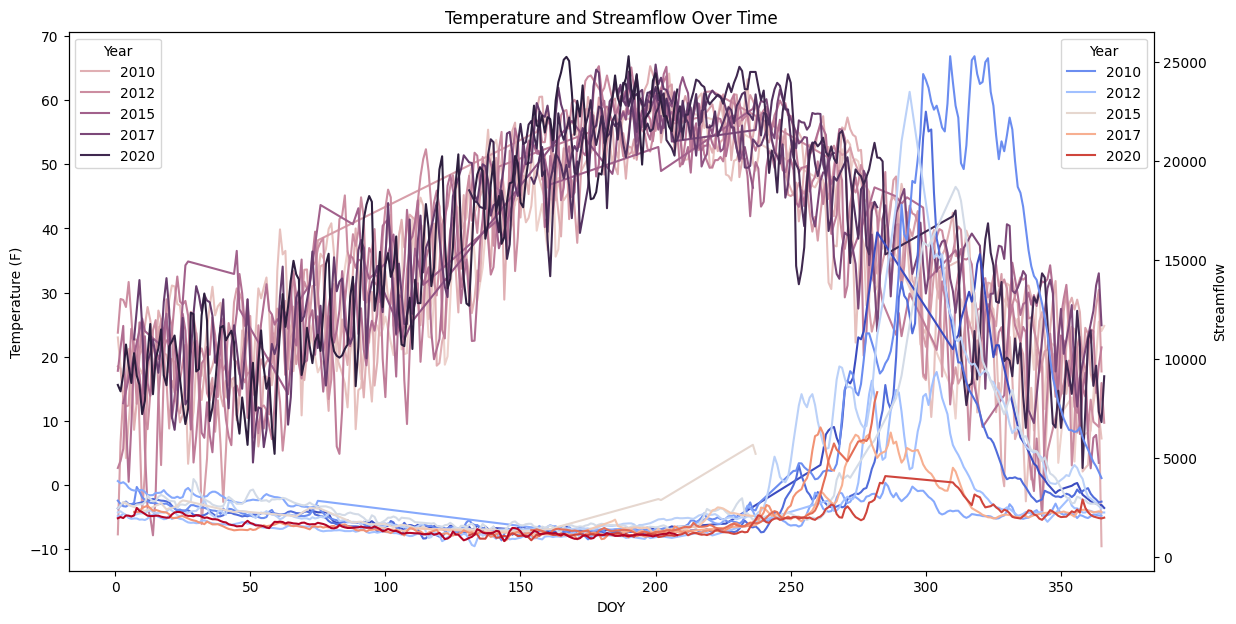

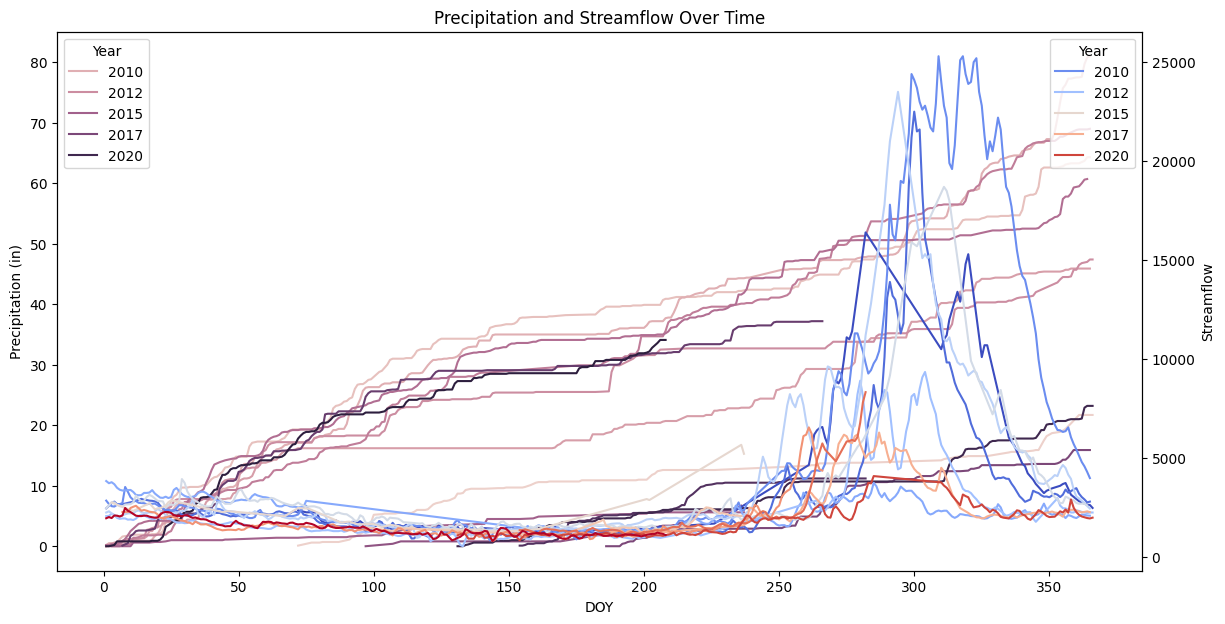

In [13]:
def plot_temp_streamflow(df):
    # plot temperature and streamflow by DOY
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # plot temperature
    sns.lineplot(data=df, x='DOY', y='TAVG', hue='year', ax=ax1)
    ax1.set_ylabel('Temperature (F)')
    ax1.set_title('Temperature and Streamflow Over Time')
    ax1.legend(title='Year', loc='upper left')

    # create a second y-axis for streamflow
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x='DOY', y='streamflow', hue='year', ax=ax2, palette='coolwarm')
    ax2.set_ylabel('Streamflow')
    ax2.legend(title='Year', loc='upper right')

    plt.show()
    
def plot_prec_streamflow(df, prec_var='PRCP'):
   # plot precipitation and streamflow by DOY
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # plot precipitation
    sns.lineplot(data=df, x='DOY', y=prec_var, hue='year', ax=ax1)
    ax1.set_ylabel('Precipitation (in)')
    ax1.set_title('Precipitation and Streamflow Over Time')
    ax1.legend(title='Year', loc='upper left')

    # create a second y-axis for streamflow
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x='DOY', y='streamflow', hue='year', ax=ax2, palette='coolwarm')
    ax2.set_ylabel('Streamflow')
    ax2.legend(title='Year', loc='upper right')

    plt.show()    

# Example usage:
plot_temp_streamflow(df)
plot_prec_streamflow(df, prec_var='PREC_year')

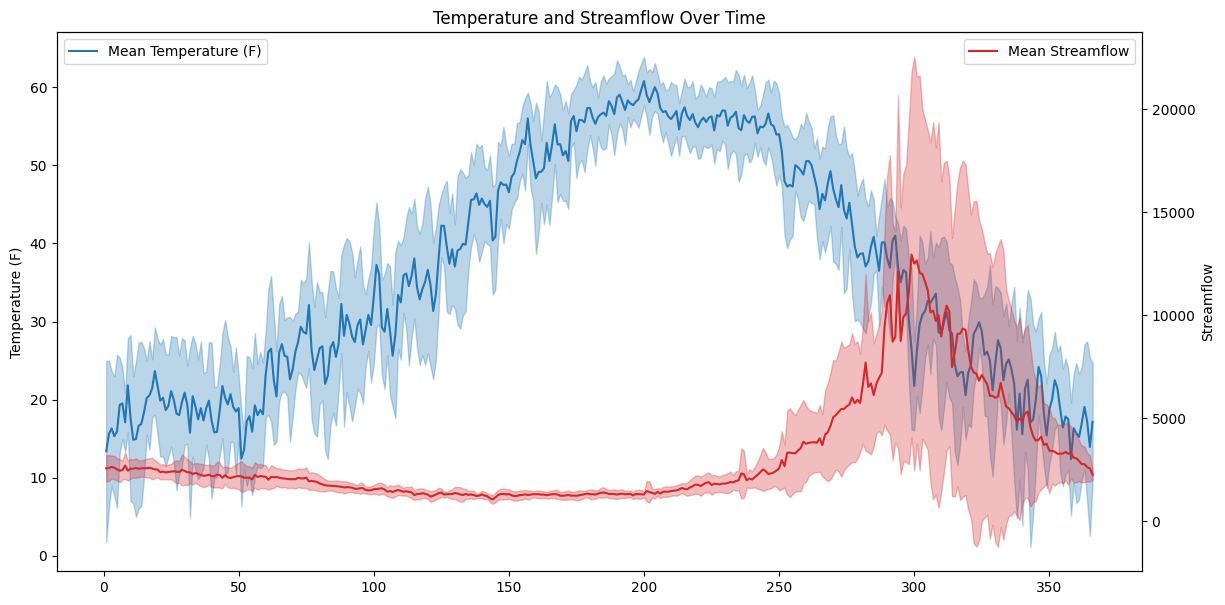

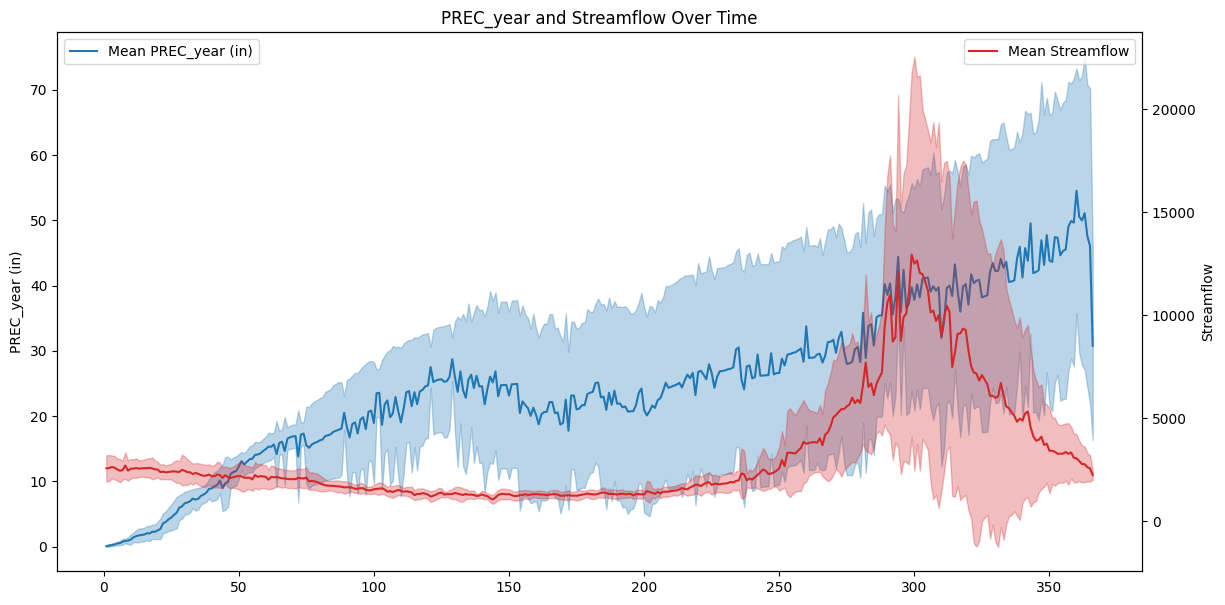

In [14]:
def plot_avg_temp_streamflow(df):
    # Calculate mean and standard deviation
    temp_mean = df.groupby('DOY')['TAVG'].mean()
    temp_std = df.groupby('DOY')['TAVG'].std()
    streamflow_mean = df.groupby('DOY')['streamflow'].mean()
    streamflow_std = df.groupby('DOY')['streamflow'].std()

    # Plot temperature and streamflow by DOY
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot temperature
    ax1.plot(temp_mean.index, temp_mean, label='Mean Temperature (F)', color='tab:blue')
    ax1.fill_between(temp_mean.index, temp_mean - temp_std, temp_mean + temp_std, color='tab:blue', alpha=0.3)
    ax1.set_ylabel('Temperature (F)')
    ax1.set_title('Temperature and Streamflow Over Time')
    ax1.legend(loc='upper left')

    # Create a second y-axis for streamflow
    ax2 = ax1.twinx()
    ax2.plot(streamflow_mean.index, streamflow_mean, label='Mean Streamflow', color='tab:red')
    ax2.fill_between(streamflow_mean.index, streamflow_mean - streamflow_std, streamflow_mean + streamflow_std, color='tab:red', alpha=0.3)
    ax2.set_ylabel('Streamflow')
    ax2.legend(loc='upper right')

    plt.show()
    
def plot_avg_prec_streamflow(df, prec_var='PRCP'):
    # Calculate mean and standard deviation
    prec_mean = df.groupby('DOY')[prec_var].mean()
    prec_std = df.groupby('DOY')[prec_var].std()
    streamflow_mean = df.groupby('DOY')['streamflow'].mean()
    streamflow_std = df.groupby('DOY')['streamflow'].std()

    # Plot precipitation and streamflow by DOY
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot precipitation
    ax1.plot(prec_mean.index, prec_mean, label=f'Mean {prec_var} (in)', color='tab:blue')
    ax1.fill_between(prec_mean.index, prec_mean - prec_std, prec_mean + prec_std, color='tab:blue', alpha=0.3)
    ax1.set_ylabel(f'{prec_var} (in)')
    ax1.set_title(f'{prec_var} and Streamflow Over Time')
    ax1.legend(loc='upper left')

    # Create a second y-axis for streamflow
    ax2 = ax1.twinx()
    ax2.plot(streamflow_mean.index, streamflow_mean, label='Mean Streamflow', color='tab:red')
    ax2.fill_between(streamflow_mean.index, streamflow_mean - streamflow_std, streamflow_mean + streamflow_std, color='tab:red', alpha=0.3)
    ax2.set_ylabel('Streamflow')
    ax2.legend(loc='upper right')

    plt.show()    

plot_avg_temp_streamflow(df)
plot_avg_prec_streamflow(df, prec_var='PREC_year')

# Data Prep for Modeling

In [15]:
df_model = df.copy()

df_model = df_model.asfreq('D')
df_model = df_model.drop(columns=['year', 'DOY'])
df_model['DOY'] = df_model.index.dayofyear # re-create DOY

# feature engineering
df_model['sin_DOY'] = np.sin(2 * np.pi * df_model['DOY'] / 365)
df_model['cos_DOY'] = np.cos(2 * np.pi * df_model['DOY'] / 365)
df_model['is_missing'] = df_model.isna().any(axis=1).astype(int)
df_model = df_model.fillna(0)
df_model = df_model[['TAVG', 'PREC_year', 'sin_DOY', 'cos_DOY', 'is_missing', 'streamflow']]
display(df_model)

df_model.to_csv('data/streamflow_prediction_tavg_prec.csv')

,TAVG,PREC_year,sin_DOY,cos_DOY,is_missing,streamflow
date,,,,,,
2008-03-12,24.80,0.1,0.945596,0.325342,0,2360.0
2008-03-13,0.00,0.0,0.951057,0.309017,1,0.0
2008-03-14,0.00,0.0,0.956235,0.292600,1,0.0
2008-03-15,17.55,0.4,0.961130,0.276097,0,2260.0
2008-03-16,0.00,0.0,0.965740,0.259512,1,0.0
...,...,...,...,...,...,...
2021-07-23,57.50,33.2,-0.361714,-0.932289,0,1170.0
2021-07-24,55.85,33.6,-0.377708,-0.925925,0,1240.0
2021-07-25,55.15,34.1,-0.393590,-0.919286,0,1190.0


# Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load data
data = df_model.copy()

# Prepare features and target
features = data.drop(columns=['streamflow'])
target = data['streamflow']

# Separate `cos_DOY`, `sin_DOY`, and `is_missing` from other features
cos_sin_doy = features[['cos_DOY', 'sin_DOY']].values  # Preserve as-is
is_missing = features['is_missing'].values.reshape(-1, 1)
other_features = features.drop(columns=['cos_DOY', 'sin_DOY', 'is_missing'])

# Scale other features
scaler_features = MinMaxScaler()
scaled_other_features = scaler_features.fit_transform(other_features)

# Concatenate `cos_DOY`, `sin_DOY`, and `is_missing` back with scaled features
scaled_features = np.concatenate([scaled_other_features, cos_sin_doy, is_missing], axis=1)

# Scale target
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Split data into training and testing sets
split_idx = int(len(data) * 0.6)
train_features, test_features = scaled_features[:split_idx], scaled_features[split_idx:]
train_target, test_target = scaled_target[:split_idx], scaled_target[split_idx:]

# Prepare sequences for RNN
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 365
rnn_train_features, rnn_train_target = create_sequences(train_features, train_target, seq_length)
rnn_test_features, rnn_test_target = create_sequences(test_features, test_target, seq_length)

# Build RNN model
rnn_model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, train_features.shape[1])),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')

# Train RNN model
rnn_model.fit(rnn_train_features, rnn_train_target, epochs=10, batch_size=32, verbose=1)

# Generate predictions
rnn_preds = rnn_model.predict(rnn_test_features)

# Inverse scale predictions and targets for comparison
rnn_preds_rescaled = scaler_target.inverse_transform(rnn_preds).flatten()
test_target_rescaled = scaler_target.inverse_transform(rnn_test_target.reshape(-1, 1)).flatten()

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(test_target_rescaled, label='Actual Streamflow', color='blue')
plt.plot(rnn_preds_rescaled, label='RNN Predictions', color='green')
plt.title('Streamflow Predictions using RNN')
plt.legend()
plt.show()

# Calculate RMSE
rnn_rmse = mean_squared_error(test_target_rescaled, rnn_preds_rescaled, squared=False)
print(f'RNN RMSE: {rnn_rmse}')

In [ ]:
rnn_model.save('models/rnn_model.h5')

# Predict with RCP 

In [172]:
# RCP Data Prep
rcp45_prec_CanRCM4 = pd.read_parquet('data/scenarios/rcp45_prec_ds_day_44i_raw_CanESM2.CanRCM4.parquet')
rcp45_temp_CanRCM4 = pd.read_parquet('data/scenarios/rcp45_temp_ds_day_44i_raw_CanESM2.CanRCM4.parquet')

# convert to inches
rcp45_prec_CanRCM4['prec'] = rcp45_prec_CanRCM4['prec'] / 25.4

# convert to F
rcp45_temp_CanRCM4['temp'] = rcp45_temp_CanRCM4['temp'] * 9/5 + 32

# set date to index
rcp45_prec_CanRCM4.set_index('time', inplace=True)
rcp45_temp_CanRCM4.set_index('time', inplace=True)
rcp45_prec_CanRCM4.index = pd.to_datetime(rcp45_prec_CanRCM4.index)
rcp45_temp_CanRCM4.index = pd.to_datetime(rcp45_temp_CanRCM4.index)

# create prec_year column
rcp45_prec_CanRCM4['prec_year'] = rcp45_prec_CanRCM4.groupby(rcp45_prec_CanRCM4.index.year)['prec'].cumsum()
rcp45_prec_CanRCM4 = rcp45_prec_CanRCM4.drop(columns=['prec'])

# asfreq to daily
rcp45_prec_CanRCM4 = rcp45_prec_CanRCM4.asfreq('D')
rcp45_temp_CanRCM4 = rcp45_temp_CanRCM4.asfreq('D')

# join
rcp45 = rcp45_prec_CanRCM4.join(rcp45_temp_CanRCM4, how='outer')

# feature engineering
rcp45['DOY'] = rcp45.index.dayofyear
rcp45['sin_DOY'] = np.sin(2 * np.pi * rcp45['DOY'] / 365)
rcp45['cos_DOY'] = np.cos(2 * np.pi * rcp45['DOY'] / 365)
rcp45['is_missing'] = rcp45.isna().any(axis=1).astype(int)
rcp45 = rcp45.fillna(0)
rcp45 = rcp45[['temp', 'prec_year', 'sin_DOY', 'cos_DOY', 'is_missing']]

rcp45.to_csv('data/rcp45_CanESM2-CanRCM4.csv')

display(rcp45)

,temp,prec_year,sin_DOY,cos_DOY,is_missing
time,,,,,
2006-01-01 12:00:00,31.084023,0.004698,1.721336e-02,0.999852,0
2006-01-02 12:00:00,22.378099,0.306288,3.442161e-02,0.999407,0
2006-01-03 12:00:00,19.533260,0.358631,5.161967e-02,0.998667,0
2006-01-04 12:00:00,13.768091,0.358631,6.880243e-02,0.997630,0
2006-01-05 12:00:00,24.457006,0.360896,8.596480e-02,0.996298,0
...,...,...,...,...,...
2100-12-27 12:00:00,39.995155,27.937475,-6.880243e-02,0.997630,0
2100-12-28 12:00:00,35.275558,27.938652,-5.161967e-02,0.998667,0
2100-12-29 12:00:00,28.253563,27.938660,-3.442161e-02,0.999407,0


In [179]:
# RCP Data Prep
rcp85_prec_CanRCM4 = pd.read_parquet('data/scenarios/rcp85_prec_ds_day_44i_raw_CanESM2.CanRCM4.parquet')
rcp85_temp_CanRCM4 = pd.read_parquet('data/scenarios/rcp85_temp_ds_day_44i_raw_CanESM2.CanRCM4.parquet')

# convert to inches
rcp85_prec_CanRCM4['prec'] = rcp85_prec_CanRCM4['prec'] / 25.4

# convert to F
rcp85_temp_CanRCM4['temp'] = rcp85_temp_CanRCM4['temp'] * 9/5 + 32

# set date to index
rcp85_prec_CanRCM4.set_index('time', inplace=True)
rcp85_temp_CanRCM4.set_index('time', inplace=True)
rcp85_prec_CanRCM4.index = pd.to_datetime(rcp85_prec_CanRCM4.index)
rcp85_temp_CanRCM4.index = pd.to_datetime(rcp85_temp_CanRCM4.index)

# create prec_year column
rcp85_prec_CanRCM4['prec_year'] = rcp85_prec_CanRCM4.groupby(rcp85_prec_CanRCM4.index.year)['prec'].cumsum()
rcp85_prec_CanRCM4 = rcp85_prec_CanRCM4.drop(columns=['prec'])

# asfreq to daily
rcp85_prec_CanRCM4 = rcp85_prec_CanRCM4.asfreq('D')
rcp85_temp_CanRCM4 = rcp85_temp_CanRCM4.asfreq('D')

# join
rcp85 = rcp85_prec_CanRCM4.join(rcp85_temp_CanRCM4, how='outer')

# feature engineering
rcp85['DOY'] = rcp85.index.dayofyear
rcp85['sin_DOY'] = np.sin(2 * np.pi * rcp85['DOY'] / 365)
rcp85['cos_DOY'] = np.cos(2 * np.pi * rcp85['DOY'] / 365)
rcp85['is_missing'] = rcp85.isna().any(axis=1).astype(int)
rcp85 = rcp85.fillna(0)
rcp85 = rcp85[['temp', 'prec_year', 'sin_DOY', 'cos_DOY', 'is_missing']]

rcp85.to_csv('data/rcp85_CanESM2-CanRCM4.csv')

display(rcp85)

,temp,prec_year,sin_DOY,cos_DOY,is_missing
time,,,,,
2006-01-01 12:00:00,31.098322,0.004412,1.721336e-02,0.999852,0
2006-01-02 12:00:00,22.391829,0.307495,3.442161e-02,0.999407,0
2006-01-03 12:00:00,19.542048,0.359011,5.161967e-02,0.998667,0
2006-01-04 12:00:00,13.775345,0.359011,6.880243e-02,0.997630,0
2006-01-05 12:00:00,24.132610,0.361916,8.596480e-02,0.996298,0
...,...,...,...,...,...
2100-12-27 12:00:00,40.788258,32.626354,-6.880243e-02,0.997630,0
2100-12-28 12:00:00,40.686527,32.643471,-5.161967e-02,0.998667,0
2100-12-29 12:00:00,37.635571,32.649437,-3.442161e-02,0.999407,0


In [195]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Extract features: temp, prec_year, sin_DOY, cos_DOY, and is_missing
features = rcp45[['temp', 'prec_year', 'sin_DOY', 'cos_DOY', 'is_missing']]

# Separate `sin_DOY`, `cos_DOY`, and `is_missing` from other features
cos_sin_doy = features[['sin_DOY', 'cos_DOY']].values  # Retain as-is
is_missing = features['is_missing'].values.reshape(-1, 1)  # Keep as binary feature
other_features = features.drop(columns=['sin_DOY', 'cos_DOY', 'is_missing'])

# Scale the other features using MinMaxScaler
scaler_features = MinMaxScaler()
scaled_other_features = scaler_features.fit_transform(other_features)

# Concatenate `cos_DOY`, `sin_DOY`, and `is_missing` back to the scaled features
scaled_features = np.concatenate([scaled_other_features, cos_sin_doy, is_missing], axis=1)

# Prepare sequences for the RNN
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
    return np.array(X)

seq_length = 365  # Use the same sequence length as during training
rnn_features = create_sequences(scaled_features, seq_length)

# Generate the corresponding years for the predictions
start_year = 2025  # Replace with the actual start year of your data
end_year = start_year + (len(features) - seq_length) // 365
years = np.linspace(start_year, end_year, len(features) - seq_length)

# Load the trained model
trained_model = load_model('models/rnn_model.h5')

# Make predictions
predictions = trained_model.predict(rnn_features)

# Reverse-transform predictions using the streamflow scaler from training
streamflow_scaler = MinMaxScaler()  # Replace this with the actual streamflow scaler
streamflow_scaler.fit(target.values.reshape(-1, 1))  # Use the target data from training
predictions_rescaled = streamflow_scaler.inverse_transform(predictions).flatten()

1073/1073 [==============================] - 12s 11ms/step


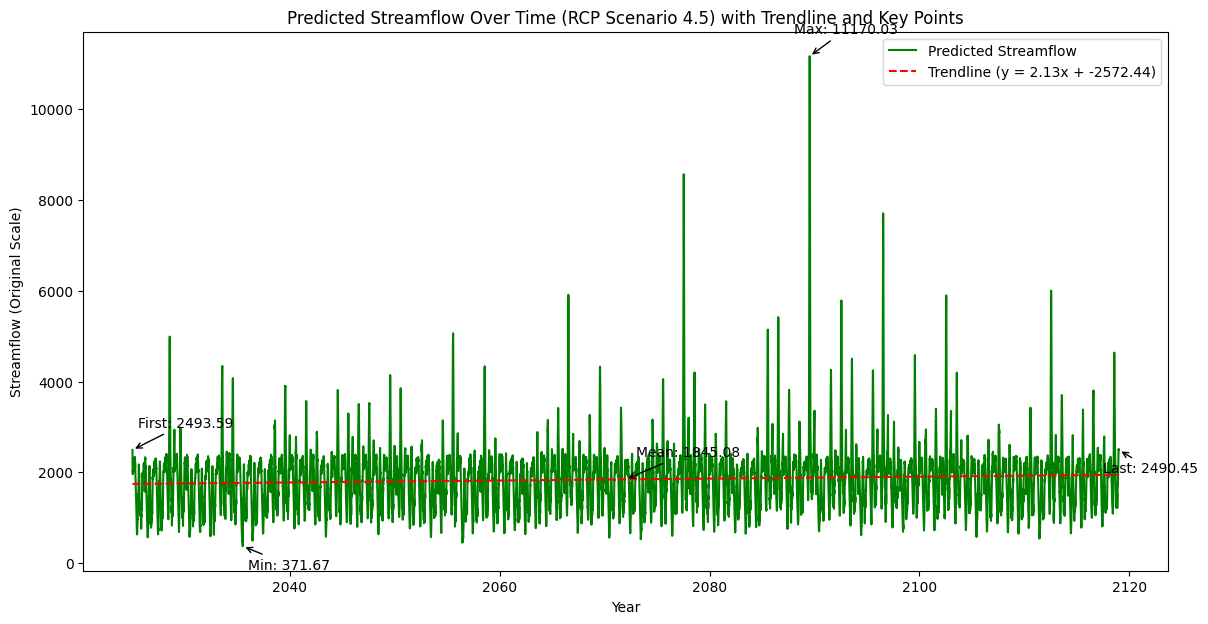

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Reshape the years for linear regression
years_reshaped = np.array(years).reshape(-1, 1)

# Fit a linear regression model to the predictions
linear_regressor = LinearRegression()
linear_regressor.fit(years_reshaped, predictions_rescaled)

# Predict trendline values
trendline = linear_regressor.predict(years_reshaped)

# Get regression equation parameters
slope = linear_regressor.coef_[0]
intercept = linear_regressor.intercept_
equation = f"y = {slope:.2f}x + {intercept:.2f}"

# Identify key points
first_year, first_streamflow = years[0], predictions_rescaled[0]
last_year, last_streamflow = years[-1], predictions_rescaled[-1]
min_streamflow_idx = np.argmin(predictions_rescaled)
max_streamflow_idx = np.argmax(predictions_rescaled)
min_year, min_streamflow = years[min_streamflow_idx], predictions_rescaled[min_streamflow_idx]
max_year, max_streamflow = years[max_streamflow_idx], predictions_rescaled[max_streamflow_idx]
mean_streamflow = np.mean(predictions_rescaled)

# Plot the predictions with the trendline
plt.figure(figsize=(14, 7))
plt.plot(years, predictions_rescaled, label='Predicted Streamflow', color='green')
plt.plot(years, trendline, label=f'Trendline ({equation})', color='red', linestyle='--')

# Add data callouts
plt.annotate(f'First: {first_streamflow:.2f}', xy=(first_year, first_streamflow),
             xytext=(first_year + 0.5, first_streamflow + 500),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

plt.annotate(f'Last: {last_streamflow:.2f}', xy=(last_year, last_streamflow),
             xytext=(last_year - 1.5, last_streamflow - 500),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

plt.annotate(f'Min: {min_streamflow:.2f}', xy=(min_year, min_streamflow),
             xytext=(min_year + 0.5, min_streamflow - 500),
             arrowprops=dict(facecolor='blue', arrowstyle='->'), fontsize=10)

plt.annotate(f'Max: {max_streamflow:.2f}', xy=(max_year, max_streamflow),
             xytext=(max_year - 1.5, max_streamflow + 500),
             arrowprops=dict(facecolor='blue', arrowstyle='->'), fontsize=10)

plt.annotate(f'Mean: {mean_streamflow:.2f}', xy=(years[len(years) // 2], mean_streamflow),
             xytext=(years[len(years) // 2] + 1, mean_streamflow + 500),
             arrowprops=dict(facecolor='purple', arrowstyle='->'), fontsize=10)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Streamflow (Original Scale)')
plt.title('Predicted Streamflow Over Time (RCP Scenario 4.5) with Trendline and Key Points')
plt.legend()
plt.show()

In [197]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Extract features: temp, prec_year, sin_DOY, cos_DOY, and is_missing
features = rcp45[['temp', 'prec_year', 'sin_DOY', 'cos_DOY', 'is_missing']]

# Separate `sin_DOY`, `cos_DOY`, and `is_missing` from other features
cos_sin_doy = features[['sin_DOY', 'cos_DOY']].values  # Retain as-is
is_missing = features['is_missing'].values.reshape(-1, 1)  # Keep as binary feature
other_features = features.drop(columns=['sin_DOY', 'cos_DOY', 'is_missing'])

# Scale the other features using MinMaxScaler
scaler_features = MinMaxScaler()
scaled_other_features = scaler_features.fit_transform(other_features)

# Concatenate `cos_DOY`, `sin_DOY`, and `is_missing` back to the scaled features
scaled_features = np.concatenate([scaled_other_features, cos_sin_doy, is_missing], axis=1)

# Prepare sequences for the RNN
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
    return np.array(X)

seq_length = 365  # Use the same sequence length as during training
rnn_features = create_sequences(scaled_features, seq_length)

# Generate the corresponding years for the predictions
start_year = 2025  # Replace with the actual start year of your data
end_year = start_year + (len(features) - seq_length) // 365
years = np.linspace(start_year, end_year, len(features) - seq_length)

# Load the trained model
trained_model = load_model('models/rnn_model.h5')

# Make predictions
predictions = trained_model.predict(rnn_features)

# Reverse-transform predictions using the streamflow scaler from training
streamflow_scaler = MinMaxScaler()  # Replace this with the actual streamflow scaler
streamflow_scaler.fit(target.values.reshape(-1, 1))  # Use the target data from training
predictions_rescaled = streamflow_scaler.inverse_transform(predictions).flatten()

1073/1073 [==============================] - 12s 11ms/step


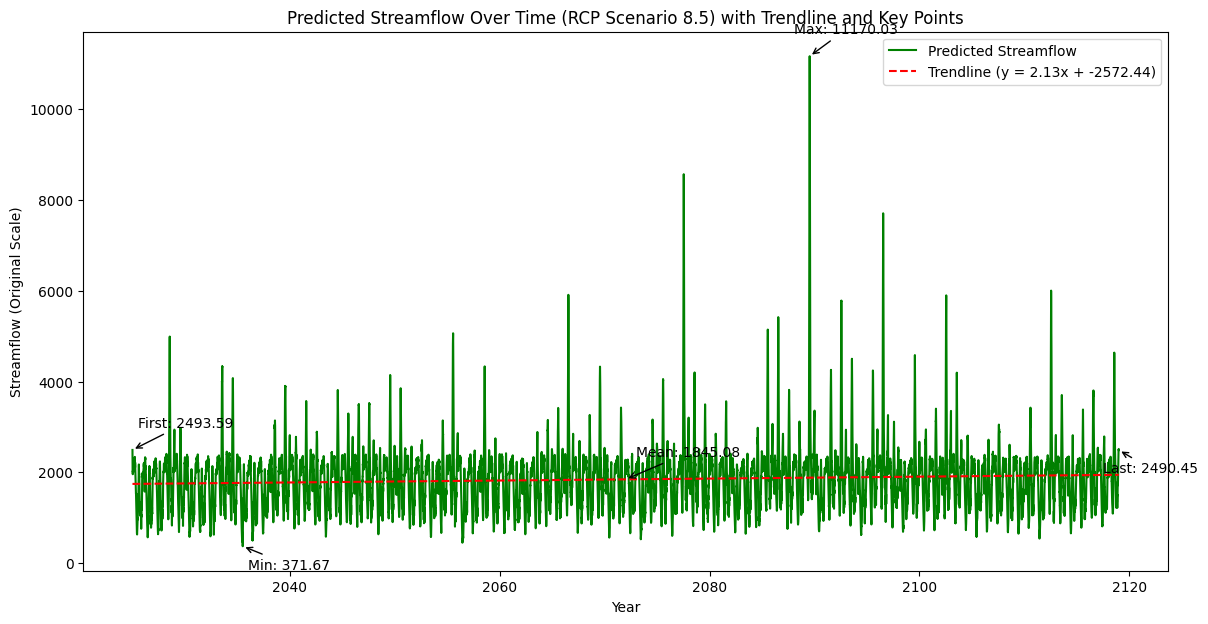

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Reshape the years for linear regression
years_reshaped = np.array(years).reshape(-1, 1)

# Fit a linear regression model to the predictions
linear_regressor = LinearRegression()
linear_regressor.fit(years_reshaped, predictions_rescaled)

# Predict trendline values
trendline = linear_regressor.predict(years_reshaped)

# Get regression equation parameters
slope = linear_regressor.coef_[0]
intercept = linear_regressor.intercept_
equation = f"y = {slope:.2f}x + {intercept:.2f}"

# Identify key points
first_year, first_streamflow = years[0], predictions_rescaled[0]
last_year, last_streamflow = years[-1], predictions_rescaled[-1]
min_streamflow_idx = np.argmin(predictions_rescaled)
max_streamflow_idx = np.argmax(predictions_rescaled)
min_year, min_streamflow = years[min_streamflow_idx], predictions_rescaled[min_streamflow_idx]
max_year, max_streamflow = years[max_streamflow_idx], predictions_rescaled[max_streamflow_idx]
mean_streamflow = np.mean(predictions_rescaled)

# Plot the predictions with the trendline
plt.figure(figsize=(14, 7))
plt.plot(years, predictions_rescaled, label='Predicted Streamflow', color='green')
plt.plot(years, trendline, label=f'Trendline ({equation})', color='red', linestyle='--')

# Add data callouts
plt.annotate(f'First: {first_streamflow:.2f}', xy=(first_year, first_streamflow),
             xytext=(first_year + 0.5, first_streamflow + 500),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

plt.annotate(f'Last: {last_streamflow:.2f}', xy=(last_year, last_streamflow),
             xytext=(last_year - 1.5, last_streamflow - 500),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

plt.annotate(f'Min: {min_streamflow:.2f}', xy=(min_year, min_streamflow),
             xytext=(min_year + 0.5, min_streamflow - 500),
             arrowprops=dict(facecolor='blue', arrowstyle='->'), fontsize=10)

plt.annotate(f'Max: {max_streamflow:.2f}', xy=(max_year, max_streamflow),
             xytext=(max_year - 1.5, max_streamflow + 500),
             arrowprops=dict(facecolor='blue', arrowstyle='->'), fontsize=10)

plt.annotate(f'Mean: {mean_streamflow:.2f}', xy=(years[len(years) // 2], mean_streamflow),
             xytext=(years[len(years) // 2] + 1, mean_streamflow + 500),
             arrowprops=dict(facecolor='purple', arrowstyle='->'), fontsize=10)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Streamflow (Original Scale)')
plt.title('Predicted Streamflow Over Time (RCP Scenario 8.5) with Trendline and Key Points')
plt.legend()
plt.show()